#ResNet

Reference:
- K. He, X. Zhang, S. Ren, and J. Sun, “Deep residual learning for image recognition,” in Proceedings of the IEEE conference on computer vision and pattern recognition, 2016, pp. 770–778. https://arxiv.org/abs/1512.03385

## 1. Xây dựng ResNet50 bằng tf.keras.layers


In [0]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt


### 1.1 Residual Block

Đầu tiên, chúng ta sẽ định nghĩa lớp ResidualBlock, lớp này sẽ xây dựng 1 khối residual. Hình trên vẽ một khối Residual cơ bản.

Các chú ý thêm:
1. Theo paper, down sampling sẽ được thực hiện ở convolutional layer đầu tiên bằng cách cho strides = [2,2]
2. Khi kích thước của input bằng kích thước của output, shorcut sẽ chính là input
3. Khi kích thước của input khác kích thước của output, shorcut sẽ là 1 lớp convolution và 1 lớp batch normalization, lớp convolution có kernel_size là [1,1];
strides và số filters được thiết lập để có cùng kích thước với output. 

In [0]:
## Import các layer cần thiết
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

## Định nghĩa 1 Residual Block
class BottleneckResidualBlock(keras.layers.Layer):

    def __init__(self, n_filters=64, kernel_regularizer=None, down_sampling=False):
        ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
        super(BottleneckResidualBlock, self).__init__()
        self.n_filters = n_filters
        self.down_sampling = down_sampling
        self.kernel_regularizer = kernel_regularizer
    
    ## override hàm này để có thể lưu file
    def get_config(self):
        ## lấy config của lớp cha
        config = super(BottleneckResidualBlock, self).get_config()
        ## thêm config của lớp này
        config.update({
            'n_filters': self.n_filters,
            "down_sampling": self.down_sampling,
        })
        return config
    
    def build(self, input_shape):
        
        ## Xác định xem input_shape có bằng output_shape không
        self.projection_shortcut = (int(input_shape[-1]) != 4*self.n_filters) or self.down_sampling
        
        ## Nếu cần down sampling thì convolutional layer đầu tiên dùng strides=[2,2]
        first_strides = [1,1]
        if self.down_sampling:
            first_strides = [2,2]
        
        ##Khai báo các layer nhánh chính
        self.main_conv1 = Convolution2D(filters=self.n_filters,
                                         kernel_size=[1,1],
                                         strides=first_strides,
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch1 = BatchNormalization()
        self.main_relu1 = ReLU()
        ##
        self.main_conv2 = Convolution2D(filters=self.n_filters,
                                              kernel_size=[3,3],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch2 = BatchNormalization()
        self.main_relu2 = ReLU()
        ##
        self.main_conv3 = Convolution2D(filters= 4*self.n_filters,
                                         kernel_size=[1,1],
                                         strides=[1,1],
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch3 = BatchNormalization()

        ## Khai báo các layer nhánh shortcut
        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(filters= 4*self.n_filters,  ### N_FILETERS bằng N_FILTERS của output
                                               kernel_size=[1,1],          ### KERNEL_SIZE = [3,3]
                                               strides=first_strides,      ### STRIDES: giống STRIDES của conv đầu
                                               padding='same',
                                               kernel_regularizer=self.kernel_regularizer,
                                               activation=None)
            self.shortcut_batch = BatchNormalization()

        self.main_relu3 = ReLU()

    def call(self, inputs):
        
        ## Thiết lập các input cho các layer đã khai báo
        main_conv1 = self.main_conv1(inputs)
        main_batch1 = self.main_batch1(main_conv1)
        main_relu1 = self.main_relu1(main_batch1)
        
        main_conv2 = self.main_conv2(main_relu1)
        main_batch2 = self.main_batch2(main_conv2)
        main_relu2 = self.main_relu2(main_batch2)

        main_conv3 = self.main_conv3(main_relu2)
        main_batch3 = self.main_batch3(main_conv3)

        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            ## Nếu input_shape != output_shape thì shortcut là convolutional layer
            shortcut = shortcut_batch
        else:
            ## Nếu input_shape == output_shape thì shortcut là inputs
            shortcut = inputs

        main_add = main_batch3 + shortcut

        main_relu3 = self.main_relu3(main_add)
        return main_relu3

In [0]:
from keras.regularizers import l2
l2_regularizer_rate = 0.0001

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = keras.layers.Input(shape=(32,32,1))

### Block 1
conv1 = Convolution2D(filters=64,
                      kernel_size=[7,7],
                      strides=[2,2],
                      padding='same',
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)
batch1 = BatchNormalization()(conv1)
relu1 = ReLU()(batch1)

maxpool1 = MaxPool2D(pool_size=(2, 2), strides=[2,2])(relu1)

## Block 2
conv2_1 = BottleneckResidualBlock(n_filters= 64,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(maxpool1)
conv2_2 = BottleneckResidualBlock(n_filters= 64,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv2_1)
conv2_3 = BottleneckResidualBlock(n_filters= 64,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv2_2)

## Block 3
conv3_1 = BottleneckResidualBlock(n_filters= 128,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=True)(conv2_3)
conv3_2 = BottleneckResidualBlock(n_filters= 128,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv3_1)
conv3_3 = BottleneckResidualBlock(n_filters= 128,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv3_2)
conv3_4 = BottleneckResidualBlock(n_filters= 128,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv3_3)

## Block 4
conv4_1 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=True)(conv3_4)
conv4_2 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv4_1)
conv4_3 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv4_2)
conv4_4 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv4_3)
conv4_5 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv4_4)
conv4_6 = BottleneckResidualBlock(n_filters= 256,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv4_5)

## Block 5
conv5_1 = BottleneckResidualBlock(n_filters= 512,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=True)(conv4_6)
conv5_2 = BottleneckResidualBlock(n_filters= 512,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv5_1)
conv5_3 = BottleneckResidualBlock(n_filters= 512,kernel_regularizer=l2(l2_regularizer_rate), down_sampling=False)(conv5_2)

### Block Output

avage_pool = GlobalAveragePooling2D()(conv5_3)

softmax = Dense(units=10, activation='softmax')(avage_pool)

## Compile model
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    ##tự khai báo Optimizer với learning rate 10^-4
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()




Cấu trúc của model: 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
bottleneck_residual_block_16 (None, 8, 8, 256)         76928     
_________________________________________________________________
bottleneck_residual_block_17 (None, 8,

### 1.3 Resize MNIST

In [0]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
## import thư viện OpenCV trên python
#!pip3 install opencv-python

### Thử resize một ảnh
import cv2
resized_img = cv2.resize(X_train[0], dsize=(32,32))
print("Kích thước ảnh sau resize: ", resized_img.shape)

Kích thước ảnh sau resize:  (32, 32)


Kích thước tập sau khi resize:  (60000, 32, 32) (10000, 32, 32)


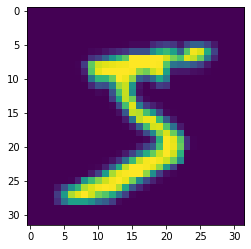

Kích thước tập sau khi reshape:  (60000, 32, 32, 1) (10000, 32, 32, 1)


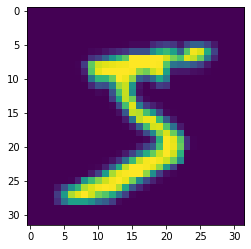

In [0]:
## Resize toàn bộ ảnh train tập train và test
X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(32,32)) for img in X_test])
print("Kích thước tập sau khi resize: ", X_train.shape, X_test.shape)

## In xem ảnh còn ổn không sau khi resize
plt.imshow(X_train[0])
plt.show()

## Reshape ảnh để phù hợp với input của model (thêm một trục)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Kích thước tập sau khi reshape: ", X_train.shape, X_test.shape)

plt.imshow(X_train[0,:,:,0])
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

## Reshape ảnh để phù hợp với input của model (thêm một trục)

### 1.4 Train

In [0]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="resnet34_mnist.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)

## Train
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])                    


## Đánh giá model trên tập test
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

## Load lại model tốt nhất đã lưu
print("best model: ")
model.load_weights("resnet34_mnist.h5")
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

Epoch 1/10
540/540 [==============================] - 28s 52ms/step - loss: 2.7029 - accuracy: 0.6852 - val_loss: 2.7892 - val_accuracy: 0.6207
Epoch 2/10
540/540 [==============================] - 27s 50ms/step - loss: 1.9779 - accuracy: 0.9015 - val_loss: 1.9541 - val_accuracy: 0.9105
Epoch 3/10
540/540 [==============================] - 27s 50ms/step - loss: 1.8155 - accuracy: 0.9501 - val_loss: 1.8716 - val_accuracy: 0.9355
Epoch 4/10
540/540 [==============================] - 27s 50ms/step - loss: 1.7445 - accuracy: 0.9697 - val_loss: 1.8301 - val_accuracy: 0.9467
Epoch 5/10
540/540 [==============================] - 27s 50ms/step - loss: 1.6989 - accuracy: 0.9798 - val_loss: 1.8021 - val_accuracy: 0.9517
Epoch 6/10
540/540 [==============================] - 26s 48ms/step - loss: 1.6819 - accuracy: 0.9802 - val_loss: 1.8234 - val_accuracy: 0.9503
Epoch 7/10
540/540 [==============================] - 27s 50ms/step - loss: 1.6502 - accuracy: 0.9835 - val_loss: 1.7548 - val_accuracy:

In [0]:
resnet50 = keras.applications.resnet50.ResNet50(include_top=True, 
                                       weights=None, 
                                       input_tensor=None, 
                                       input_shape=(32,32,1), 
                                       pooling=None,
                                       classes=10)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________